In [16]:
import os
import torch
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# utility function to convert RGB into gray-scale images with COLOR CHANNELS IN LAST DIMENSION
def rgb2gray(images):
    return 0.299*images[:, :, :, 0] + 0.587*images[:, :, :, 1] + 0.114*images[:, :, :, 2]


# call it as 'loss = ... + torch.mean(fourier_dissimilarity(fake_images, real_images, metric))'
# metric can be one of the following: '1' (1-norm of difference),
#                                     '2' (frobenius norm of difference),
#                                     'cos' (cosine dissimilarity)
def fourier_dissimilarity(fake_images, real_images, metric, thres=1):
    #fake_images = fake_images.permute(0, 2, 3, 1)
    #real_images = real_images.permute(0, 2, 3, 1)
    fake_ft = torch.norm(torch.rfft(rgb2gray(fake_images), signal_ndim=2), dim=3)
    real_ft = torch.norm(torch.rfft(rgb2gray(real_images), signal_ndim=2), dim=3)
    if metric == '1':
        return torch.norm(fake_ft[:,thres:-thres,thres:]-real_ft[:,thres:-thres,thres:], p=1, dim=(1, 2))*1e-8
    elif metric == '2':
        return torch.norm(fake_ft[:,thres:-thres,thres:]-real_ft[:,thres:-thres,thres:], p='fro', dim=(1, 2))
    elif metric == 'cos':
        vec_fake_ft = torch.flatten(fake_ft[:,thres:-thres,thres:], start_dim=1).unsqueeze(dim=1)
        vec_real_ft = torch.flatten(real_ft[:,thres:-thres,thres:], start_dim=1).unsqueeze(dim=2)
        return 1 - torch.bmm(vec_fake_ft, vec_real_ft).squeeze() / (torch.norm(vec_fake_ft, dim=2) * torch.norm(vec_real_ft, dim=1)).squeeze()
    else:
        return 0

In [3]:
path = '/Users/max/Desktop/realZfake_res/'

In [4]:
# load images

real_list = []
fake_list = []

real_files = sorted(os.listdir(path+'real'))
fake_files = sorted(os.listdir(path+'fake'))

for idx in range(len(real_files)):
    real_list.append(plt.imread(path+'real/'+real_files[idx]))
    fake_list.append(plt.imread(path+'fake/'+fake_files[idx]))
    
real = torch.from_numpy(np.array(real_list))
fake = torch.from_numpy(np.array(fake_list)[:,:,:,:3])

torch.Size([8, 256, 256, 3])

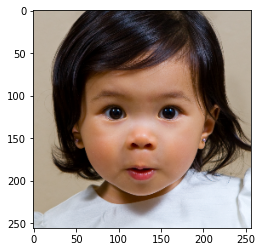

In [5]:
plt.imshow(real[1])
fake.shape

In [17]:
# compute fourier dissimilarity for different frequency thresholds

fd_1_list = []
fd_2_list = []
fd_cos_list = []

thresholds = np.arange(1, 120)

start = time.time()

for thres in thresholds:
    
    fd_1_list.append(fourier_dissimilarity(real, fake, '1', thres).numpy())
    fd_2_list.append(fourier_dissimilarity(real, fake, '2', thres).numpy())
    fd_cos_list.append(fourier_dissimilarity(real, fake, 'cos', thres).numpy())
    
print(time.time()-start)
    
fd_1 = np.array(fd_1_list)
fd_2 = np.array(fd_2_list)
fd_cos = np.array(fd_cos_list)

27.05762481689453


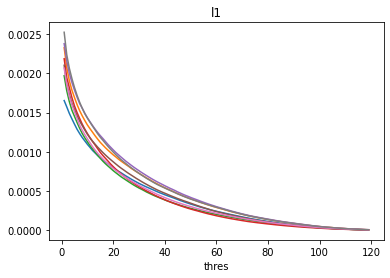

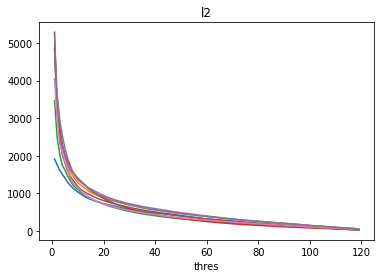

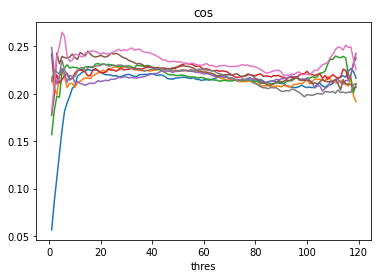

In [24]:
# plot results

plt.plot(thresholds, fd_1)#/((256-2*thresholds)*(128-thresholds))[:,None])
plt.xlabel('thres')
plt.title('l1')
plt.show()

plt.plot(thresholds, fd_2)#/((256-2*thresholds)*(128-thresholds))[:,None])
plt.xlabel('thres')
plt.title('l2')
plt.show()

plt.plot(thresholds, fd_cos)
plt.xlabel('thres')
plt.title('cos')
plt.show()